In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import seaborn as sbn

In [2]:
sys.path.insert(0, os.path.abspath('../'))
print(os.path.abspath('../'))
from uncertainty_estimation.experiments_utils.ood_experiments_utils import EICU_OOD_MAPPINGS

/home/dennis/uncertainty_estimation


In [3]:
EICU_PATH = "/data/processed/eicu_processed/data/adult_data.csv"
MIMIC_PATH = "/data/processed/benchmark/inhospitalmortality/not_scaled/train_data_processed_w_static.csv"
EICU_TARGET = "hospitaldischargestatus"
MIMIC_TARGET = "y"

In [4]:
with open("../uncertainty_estimation/experiments_utils/common_eicu_params.pkl", "rb") as f:
    eicu_feat_columns = pickle.load(f)
    
with open("../uncertainty_estimation/experiments_utils/common_mimic_params.pkl", "rb") as f:
    mimic_feat_columns = pickle.load(f)

In [5]:
eicu_data = pd.read_csv(EICU_PATH)
mimic_data = pd.read_csv(MIMIC_PATH)

In [6]:
all_data = np.concatenate([eicu_data[eicu_feat_columns].values, mimic_data[mimic_feat_columns].values])

In [7]:
print(all_data.shape)

(52753, 588)


In [15]:
from sklearn import pipeline
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

scaler = StandardScaler()
scaler.fit(all_data)
eicu_imputer = SimpleImputer()
imputed_eicu_data = scaler.transform(eicu_data[eicu_feat_columns].values)
imputed_eicu_data = eicu_imputer.fit_transform(imputed_eicu_data)

mimic_imputer = SimpleImputer()
imputed_mimic_data = scaler.transform(mimic_data[mimic_feat_columns].values)
imputed_mimic_data = mimic_imputer.fit_transform(imputed_mimic_data)

#pipe = pipeline.Pipeline(
#    [("scaler", StandardScaler()), ("imputer", SimpleImputer())]
#)
#pipe.fit(all_data.copy())
#data_scaled = pipe.transform(all_data.copy())
data_scaled = np.concatenate([imputed_eicu_data, imputed_mimic_data])

In [18]:
tsne = TSNE(verbose=2, n_jobs=-1)
data_projected = tsne.fit_transform(data_scaled)
np.save("eicu_mimic_projected2.npy", data_projected)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 52753 samples in 16.896s...
[t-SNE] Computed neighbors for 52753 samples in 541.602s...
[t-SNE] Computed conditional probabilities for sample 1000 / 52753
[t-SNE] Computed conditional probabilities for sample 2000 / 52753
[t-SNE] Computed conditional probabilities for sample 3000 / 52753
[t-SNE] Computed conditional probabilities for sample 4000 / 52753
[t-SNE] Computed conditional probabilities for sample 5000 / 52753
[t-SNE] Computed conditional probabilities for sample 6000 / 52753
[t-SNE] Computed conditional probabilities for sample 7000 / 52753
[t-SNE] Computed conditional probabilities for sample 8000 / 52753
[t-SNE] Computed conditional probabilities for sample 9000 / 52753
[t-SNE] Computed conditional probabilities for sample 10000 / 52753
[t-SNE] Computed conditional probabilities for sample 11000 / 52753
[t-SNE] Computed conditional probabilities for sample 12000 / 52753
[t-SNE] Computed conditional probabilities for 

In [19]:
data_projected = np.load("eicu_mimic_projected2.npy")

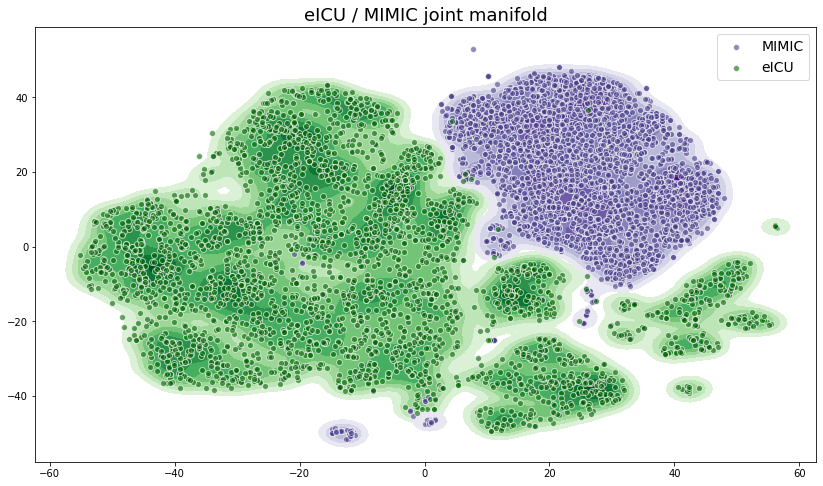

In [21]:
plt.rcParams["figure.figsize"] = (14,8)
fig, ax = plt.subplots()

# Plot joint manifold
# Plot densities first
ax = sbn.kdeplot(data_projected[:len(eicu_data), 0], data_projected[:len(eicu_data), 1], cmap="Greens", bw=2, shade=True, shade_lowest=False)
ax = sbn.kdeplot(data_projected[len(eicu_data):, 0], data_projected[len(eicu_data):, 1], cmap="Purples", bw=2, shade=True, shade_lowest=False)

# Sample some points and plot those
num_plotted_points = 3000
eicu_indices = np.random.choice(np.arange(len(eicu_data)), num_plotted_points)
mimic_indices = np.random.choice(np.arange(len(eicu_data), len(eicu_data) + len(mimic_data)), num_plotted_points)
ax.scatter(
    data_projected[eicu_indices, 0], data_projected[eicu_indices, 1], 
    alpha=0.6, c="darkgreen", label="eICU", edgecolor="w"
)

ax.scatter(
    data_projected[mimic_indices, 0], data_projected[mimic_indices, 1], 
    alpha=0.6, c="darkslateblue", label="MIMIC", edgecolor="w"
)

plt.title(f"eICU / MIMIC joint manifold", fontsize=18)
plt.legend(fontsize=14)

plt.savefig(f"./eicu_mimic_manifold.png")
plt.show()

In [22]:
from uncertainty_estimation.experiments_utils.ood_experiments_utils import EICU_OOD_MAPPINGS, MIMIC_OOD_MAPPINGS

In [40]:
plt.rcParams["figure.figsize"] = (14,8)

def plot_group(group_name, X, y):
    kde_ax = sbn.kdeplot(data_projected[:len(eicu_data), 0], data_projected[:len(eicu_data), 1], cmap="Greens", bw=2, shade=True, shade_lowest=False)
    kde_ax = sbn.kdeplot(data_projected[len(eicu_data):, 0], data_projected[len(eicu_data):, 1], cmap="Purples", bw=2, shade=True, shade_lowest=False, ax=kde_ax)

    kde_ax.scatter(
        X[:, 0][y == 1], X[:, 1][y == 1], 
        alpha=0.6, c="tab:gray", label="Targets", edgecolor="w"
    )
    plt.title(f"eICU / MIMIC stays '{group_name}' ({y.mean()*100:.2f} %)", fontsize=18)
    plt.legend(fontsize=14)
    plt.savefig(f"./eicu_mimic_{group_name.lower().replace('/', '_')}.png")
    plt.show()

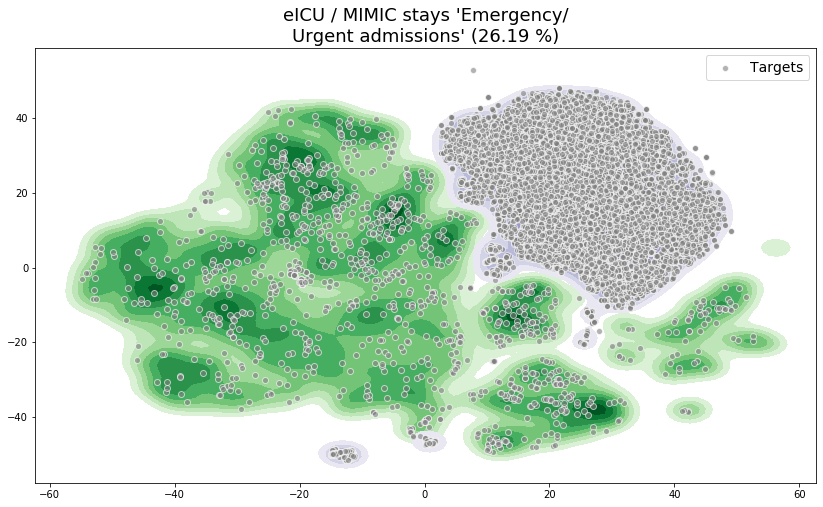

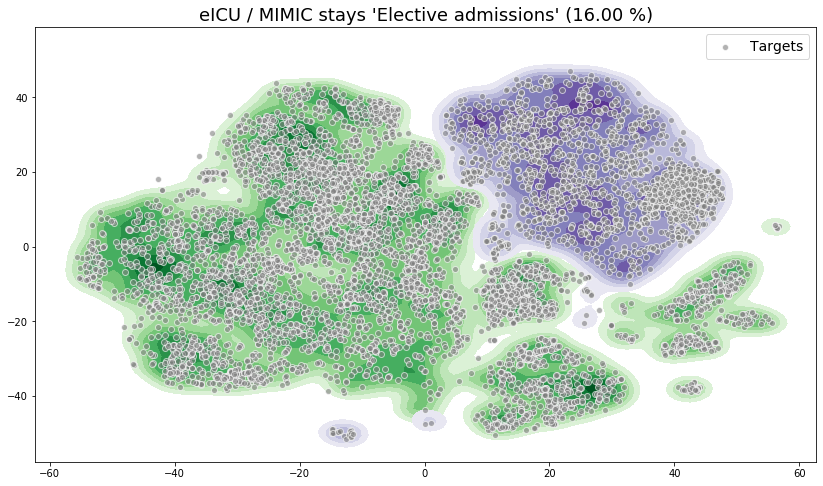

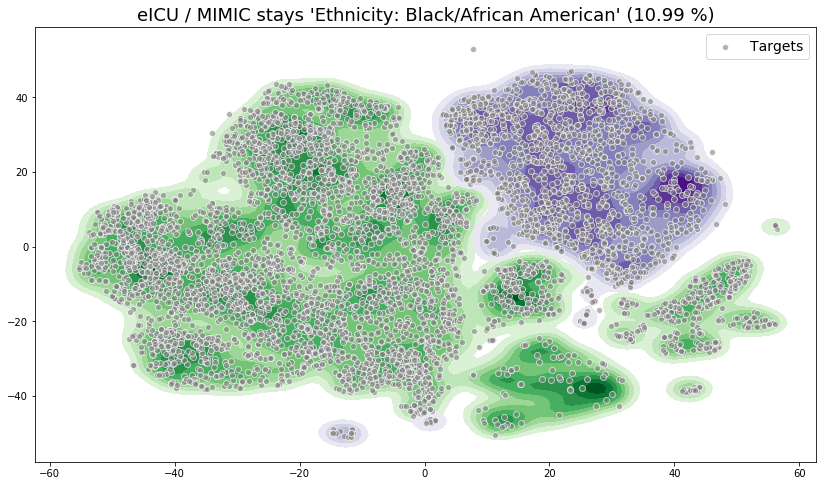

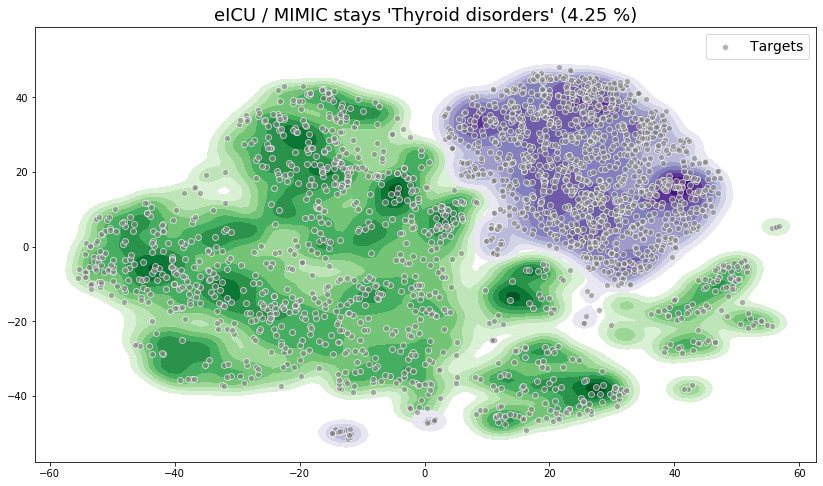

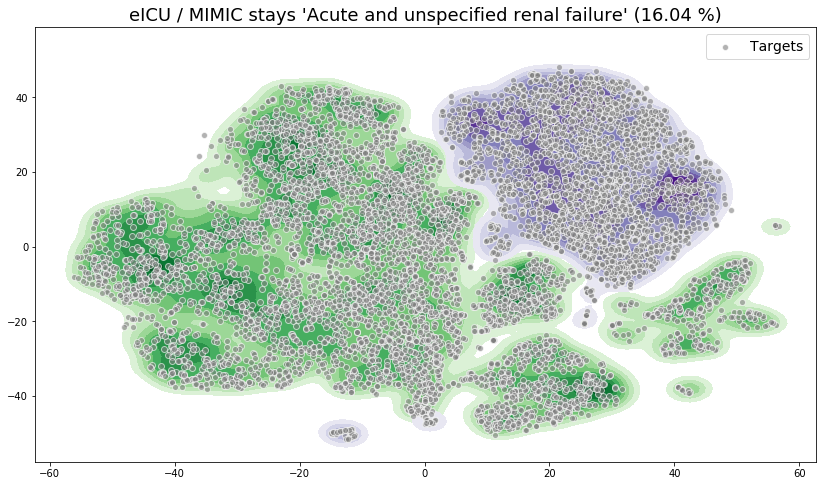

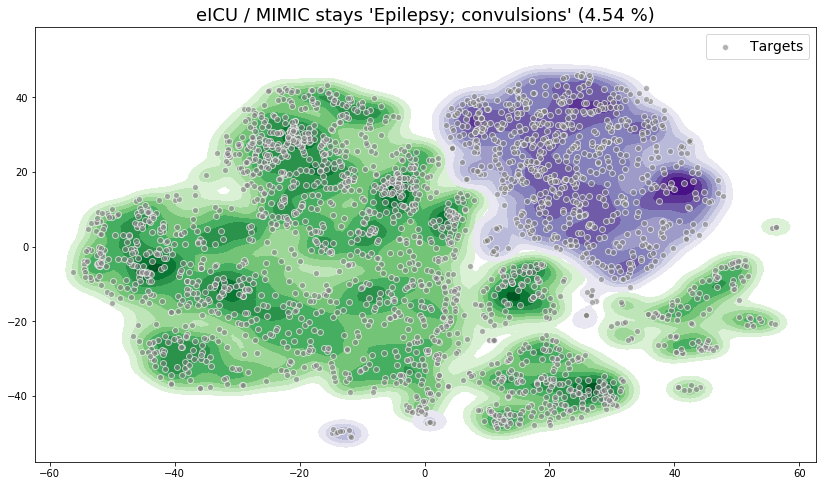

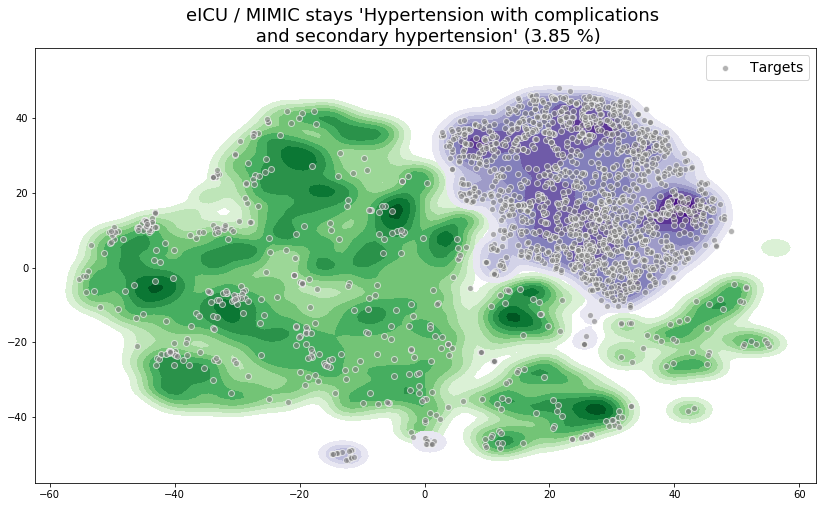

In [41]:
for (group_name, filter_value_eicu), (_, filter_value_mimic) in zip(EICU_OOD_MAPPINGS.items(), MIMIC_OOD_MAPPINGS.items()):
    col_eicu, val_eicu = filter_value_eicu
    col_mimic, val_mimic = filter_value_mimic
    y_group_eicu = (eicu_data[col_eicu] == val_eicu).to_numpy()
    y_group_mimic = (mimic_data[col_mimic] == val_mimic).to_numpy()
    y_group = np.concatenate([y_group_eicu, y_group_mimic])
    plot_group(group_name, data_projected, y_group)